In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import warnings
import pickle
warnings.filterwarnings(action='ignore')


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)
# define 'device' to upload tensor in gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sklearn
from sklearn.neighbors import KNeighborsRegressor

from utils.preprocess_utils import *
from utils.train_utils import *
from models.model_cycle.cycle_lstm import LSTMModel_cycle

In [2]:
with open('data/preprocess/m_data_list.pkl', 'rb') as f:
#with open('data/preprocess/l_data_list.pkl', 'rb') as f:
#with open('data/preprocess/e_data_list.pkl', 'rb') as f:
#with open('data/preprocess/full_data_list.pkl', 'rb') as f:
    data_list = pickle.load(f)

train_time, train_notime, train_y,\
valid_time, valid_notime, valid_y, \
    test_time, test_notime, test_y = numpy2tensor(data_list)

In [4]:
# hidden state : 전달과정 중간 출력의 차원
model = LSTMModel_cycle(input_size = 10, hidden_size = 32, no_time_size = 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)

# Train model
num_epochs  = 500
hist = np.zeros(num_epochs)

train_error = []
valid_error = []

hist = {'best_val_error': 100,
        'best_val_epoch': 0}


for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()  
    # Forward pass
    train_pred = model(train_time, train_notime)
    loss = criterion(train_pred, train_y[:,:,1])
    train_error.append(loss)

    valid_pred = model(valid_time, valid_notime)
    valid_mse = float(criterion(valid_pred, valid_y[:,:,1]).cpu())
    valid_error.append(valid_mse)

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
    
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t

    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")

10 Epochs train MSE: 0.14103 // valid MSE: 0.16033
20 Epochs train MSE: 0.06204 // valid MSE: 0.13488
30 Epochs train MSE: 0.03488 // valid MSE: 0.15499
40 Epochs train MSE: 0.02214 // valid MSE: 0.15427
50 Epochs train MSE: 0.01864 // valid MSE: 0.14663
60 Epochs train MSE: 0.01631 // valid MSE: 0.13895
70 Epochs train MSE: 0.01484 // valid MSE: 0.13703
80 Epochs train MSE: 0.01375 // valid MSE: 0.14031
90 Epochs train MSE: 0.01272 // valid MSE: 0.13824
100 Epochs train MSE: 0.01194 // valid MSE: 0.13978
110 Epochs train MSE: 0.01131 // valid MSE: 0.13751
120 Epochs train MSE: 0.01071 // valid MSE: 0.13894
130 Epochs train MSE: 0.01025 // valid MSE: 0.14162
140 Epochs train MSE: 0.01009 // valid MSE: 0.14234
150 Epochs train MSE: 0.00956 // valid MSE: 0.14388
160 Epochs train MSE: 0.00900 // valid MSE: 0.14432
170 Epochs train MSE: 0.00857 // valid MSE: 0.14597
180 Epochs train MSE: 0.00810 // valid MSE: 0.14749
190 Epochs train MSE: 0.00815 // valid MSE: 0.15130
200 Epochs train MSE:

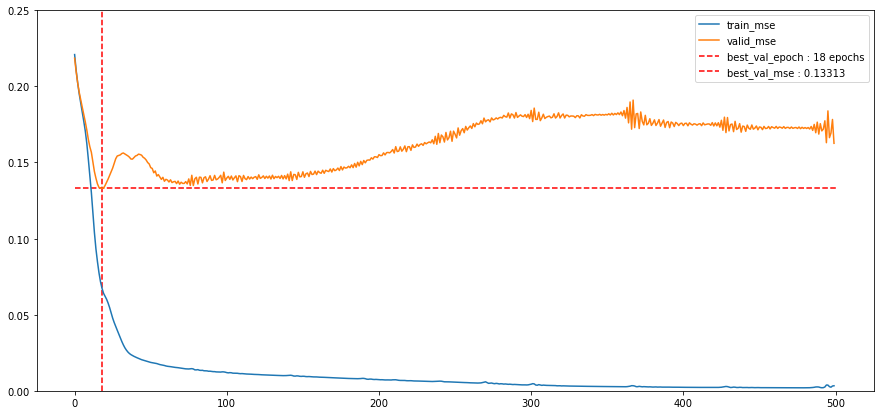

In [7]:
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

In [14]:
train_x_np, train_y_np, train_pred_np,\
valid_time_x_np, valid_notime_x_np, valid_y_np = tensor2numpy([train_time[:,:,-1], train_y[:,:,1], train_pred,
                                                        valid_time[:,:,-1], valid_y[:,:,1], valid_pred])

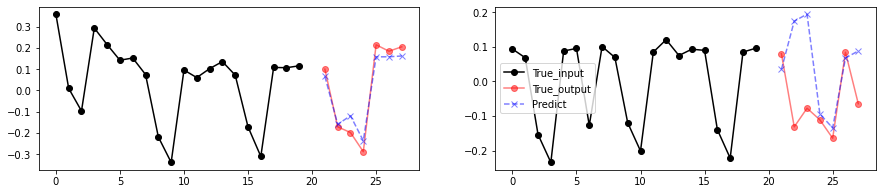

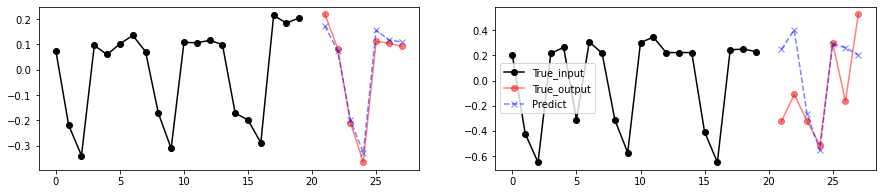

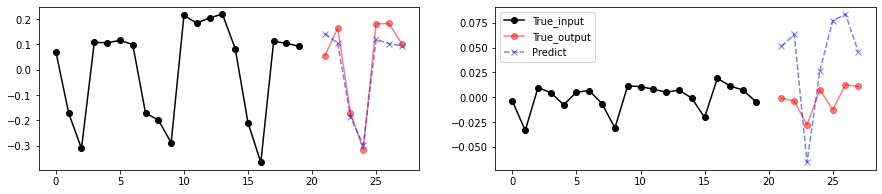

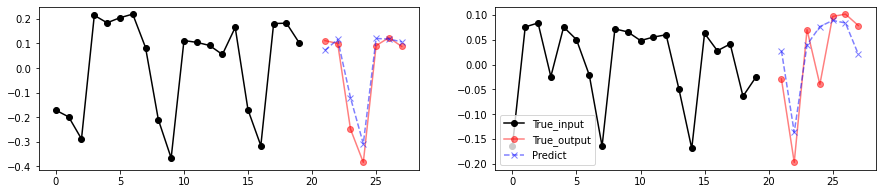

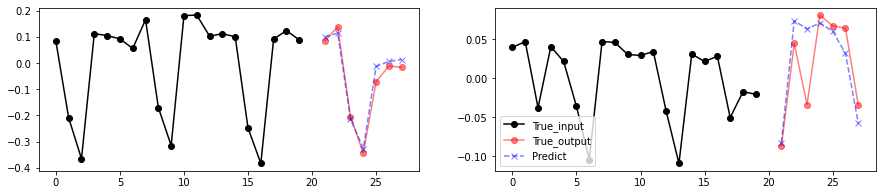

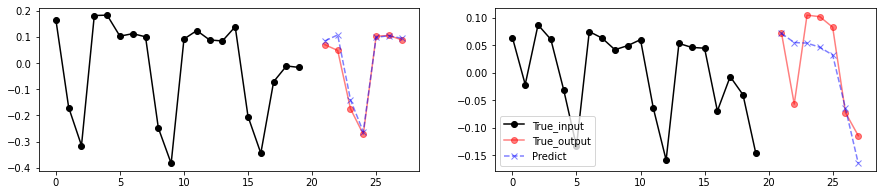

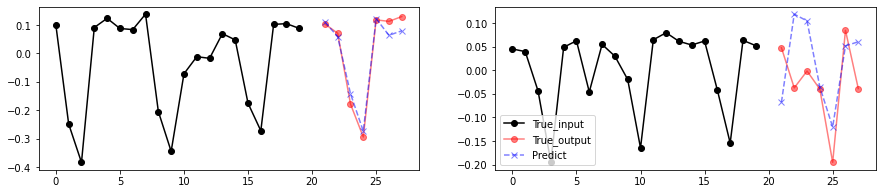

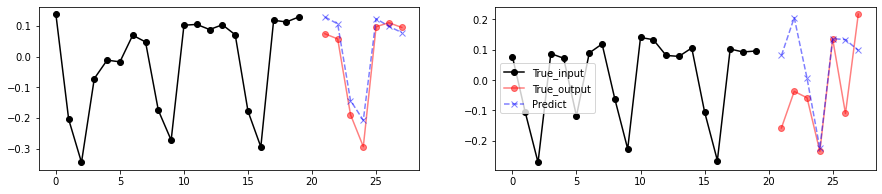

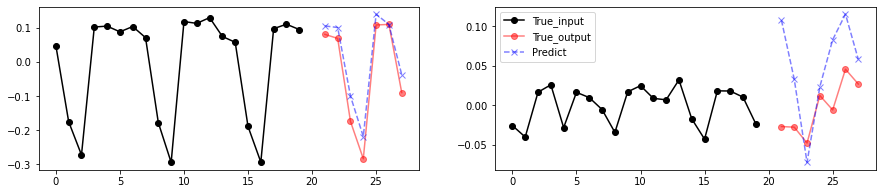

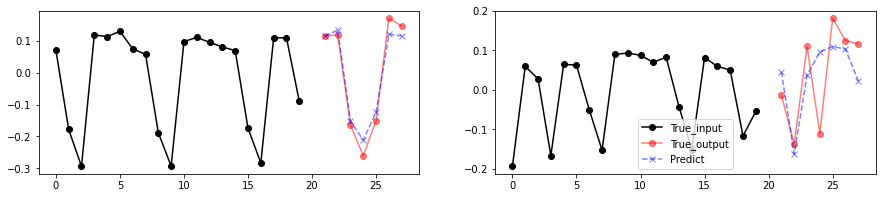

In [15]:
plot_predict(train_x_np, train_y_np, train_pred_np,\
                valid_time_x_np, valid_notime_x_np, valid_y_np)

In [16]:
cycle_result_list = [train_x_np, train_y_np, train_pred_np,\
                valid_time_x_np, valid_notime_x_np, valid_y_np]

In [17]:
path = 'data/train_results/'
with open(path + 'm_cycle_results_list.pkl', 'wb') as f:
    pickle.dump(cycle_result_list, f)